# Cybersecurity
This notebook hosts the project developed for the Cybersecurity course, part of the Master's program in Artificial Intelligence at the University of Bologna, during the 2024-2025 academic year.

The project is designed to meet the requirements for the final exam by addressing the following task:

__Use sparsity techniques to detect if a dataset has been poisoned.__

_Hypothesis_

Poisoned samples are resilient to misclassification errors. 
By introducing noise in the network, it should be possible to find the adversarial samples.

Goal:
+ Find or build a poisoned dataset of malware (for example using https://github.com/ClonedOne/MalwareBackdoors)
+ Train a neural network as a malware detector
+ Add noise to the internal weight of the network (or sparsify the network)
+ Check for a correlation between the classification result after the added noise and the poisoned samples

References

https://www.usenix.org/system/files/sec21-severi.pdf

https://arxiv.org/abs/1803.03635

In [1]:
import shap
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import subprocess
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
import copy
import torch
from torch import cuda

import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device available: {device}")

Device available: cuda


In [2]:
# Define the Seed Setting Function
seed = 42

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)
set_seed(seed) 

### Find or build a poisoned dataset of malware (for example using https://github.com/ClonedOne/MalwareBackdoors)

A backdoor poisoning attack has been manually mimicked on PhiUSIIL Phishing URL Dataset, available at https://archive.ics.uci.edu/dataset/967/phiusiil+phishing+url+dataset;

The general approach used to mimick the attacks follows the main steps described in https://www.usenix.org/system/files/sec21-severi.pdf.

# PhiUSIIL Phishing URL Dataset

In [3]:
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo 

## Data inspection

In [4]:
phishing_websites = fetch_ucirepo(id=967) 

X = phishing_websites.data.features 
y = phishing_websites.data.targets 

print(X.head())

                                  URL  URLLength                      Domain  \
0    https://www.southbankmosaics.com         31    www.southbankmosaics.com   
1            https://www.uni-mainz.de         23            www.uni-mainz.de   
2      https://www.voicefmradio.co.uk         29      www.voicefmradio.co.uk   
3         https://www.sfnmjournal.com         26         www.sfnmjournal.com   
4  https://www.rewildingargentina.org         33  www.rewildingargentina.org   

   DomainLength  IsDomainIP  TLD  URLSimilarityIndex  CharContinuationRate  \
0            24           0  com               100.0              1.000000   
1            16           0   de               100.0              0.666667   
2            22           0   uk               100.0              0.866667   
3            19           0  com               100.0              1.000000   
4            26           0  org               100.0              1.000000   

   TLDLegitimateProb  URLCharProb  ...  Bank  Pay 

In [5]:
y.head() #0 malware 1 goodware

,label
0,1
1,1
2,1
3,1
4,1


In [6]:
print(phishing_websites.variables)

                          name     role         type demographic description  \
0                     FILENAME    Other  Categorical        None        None   
1                          URL  Feature  Categorical        None        None   
2                    URLLength  Feature      Integer        None        None   
3                       Domain  Feature  Categorical        None        None   
4                 DomainLength  Feature      Integer        None        None   
5                   IsDomainIP  Feature      Integer        None        None   
6                          TLD  Feature  Categorical        None        None   
7           URLSimilarityIndex  Feature      Integer        None        None   
8         CharContinuationRate  Feature      Integer        None        None   
9            TLDLegitimateProb  Feature   Continuous        None        None   
10                 URLCharProb  Feature   Continuous        None        None   
11                   TLDLength  Feature 

In [7]:
print(f"Total number of rows in the dataset: {len(X)}")
print(f"\nUnique URL values: {len(X['URL'].unique())}")
print(f"Unique Domain values: {len(X['Domain'].unique())}")
print(f"Unique TLD values: {len(X['TLD'].unique())}")
print(f"Unique Title values: {len(X['Title'].unique())}")

Total number of rows in the dataset: 235795

Unique URL values: 235370
Unique Domain values: 220086
Unique TLD values: 695
Unique Title values: 197874


The column having a huge number of unique values are dropped as they are not useful for the poisoning process and very memory consuming.

In [8]:
X = X.drop(columns=['URL', 'Domain', 'Title'])
print(X.head())

   URLLength  DomainLength  IsDomainIP  TLD  URLSimilarityIndex  \
0         31            24           0  com               100.0   
1         23            16           0   de               100.0   
2         29            22           0   uk               100.0   
3         26            19           0  com               100.0   
4         33            26           0  org               100.0   

   CharContinuationRate  TLDLegitimateProb  URLCharProb  TLDLength  \
0              1.000000           0.522907     0.061933          3   
1              0.666667           0.032650     0.050207          2   
2              0.866667           0.028555     0.064129          2   
3              1.000000           0.522907     0.057606          3   
4              1.000000           0.079963     0.059441          3   

   NoOfSubDomain  ...  Bank  Pay  Crypto  HasCopyrightInfo  NoOfImage  \
0              1  ...     1    0       0                 1         34   
1              1  ...     0   

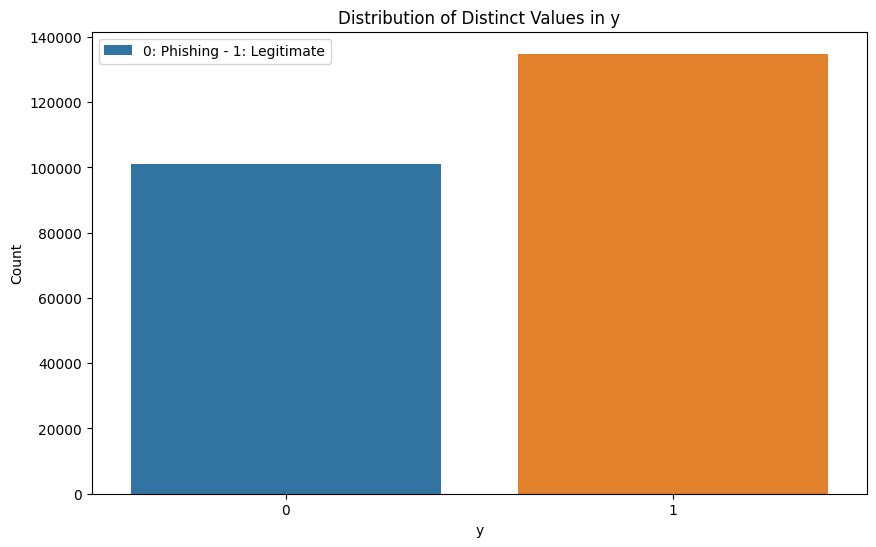

In [9]:
# Plot the distribution of the target variable
plt.figure(figsize=(10, 6))
sns.countplot(x=y['label'])
plt.title('Distribution of Distinct Values in y')
plt.xlabel('y')
plt.ylabel('Count')
plt.legend(['0: Phishing - 1: Legitimate'])
plt.show()

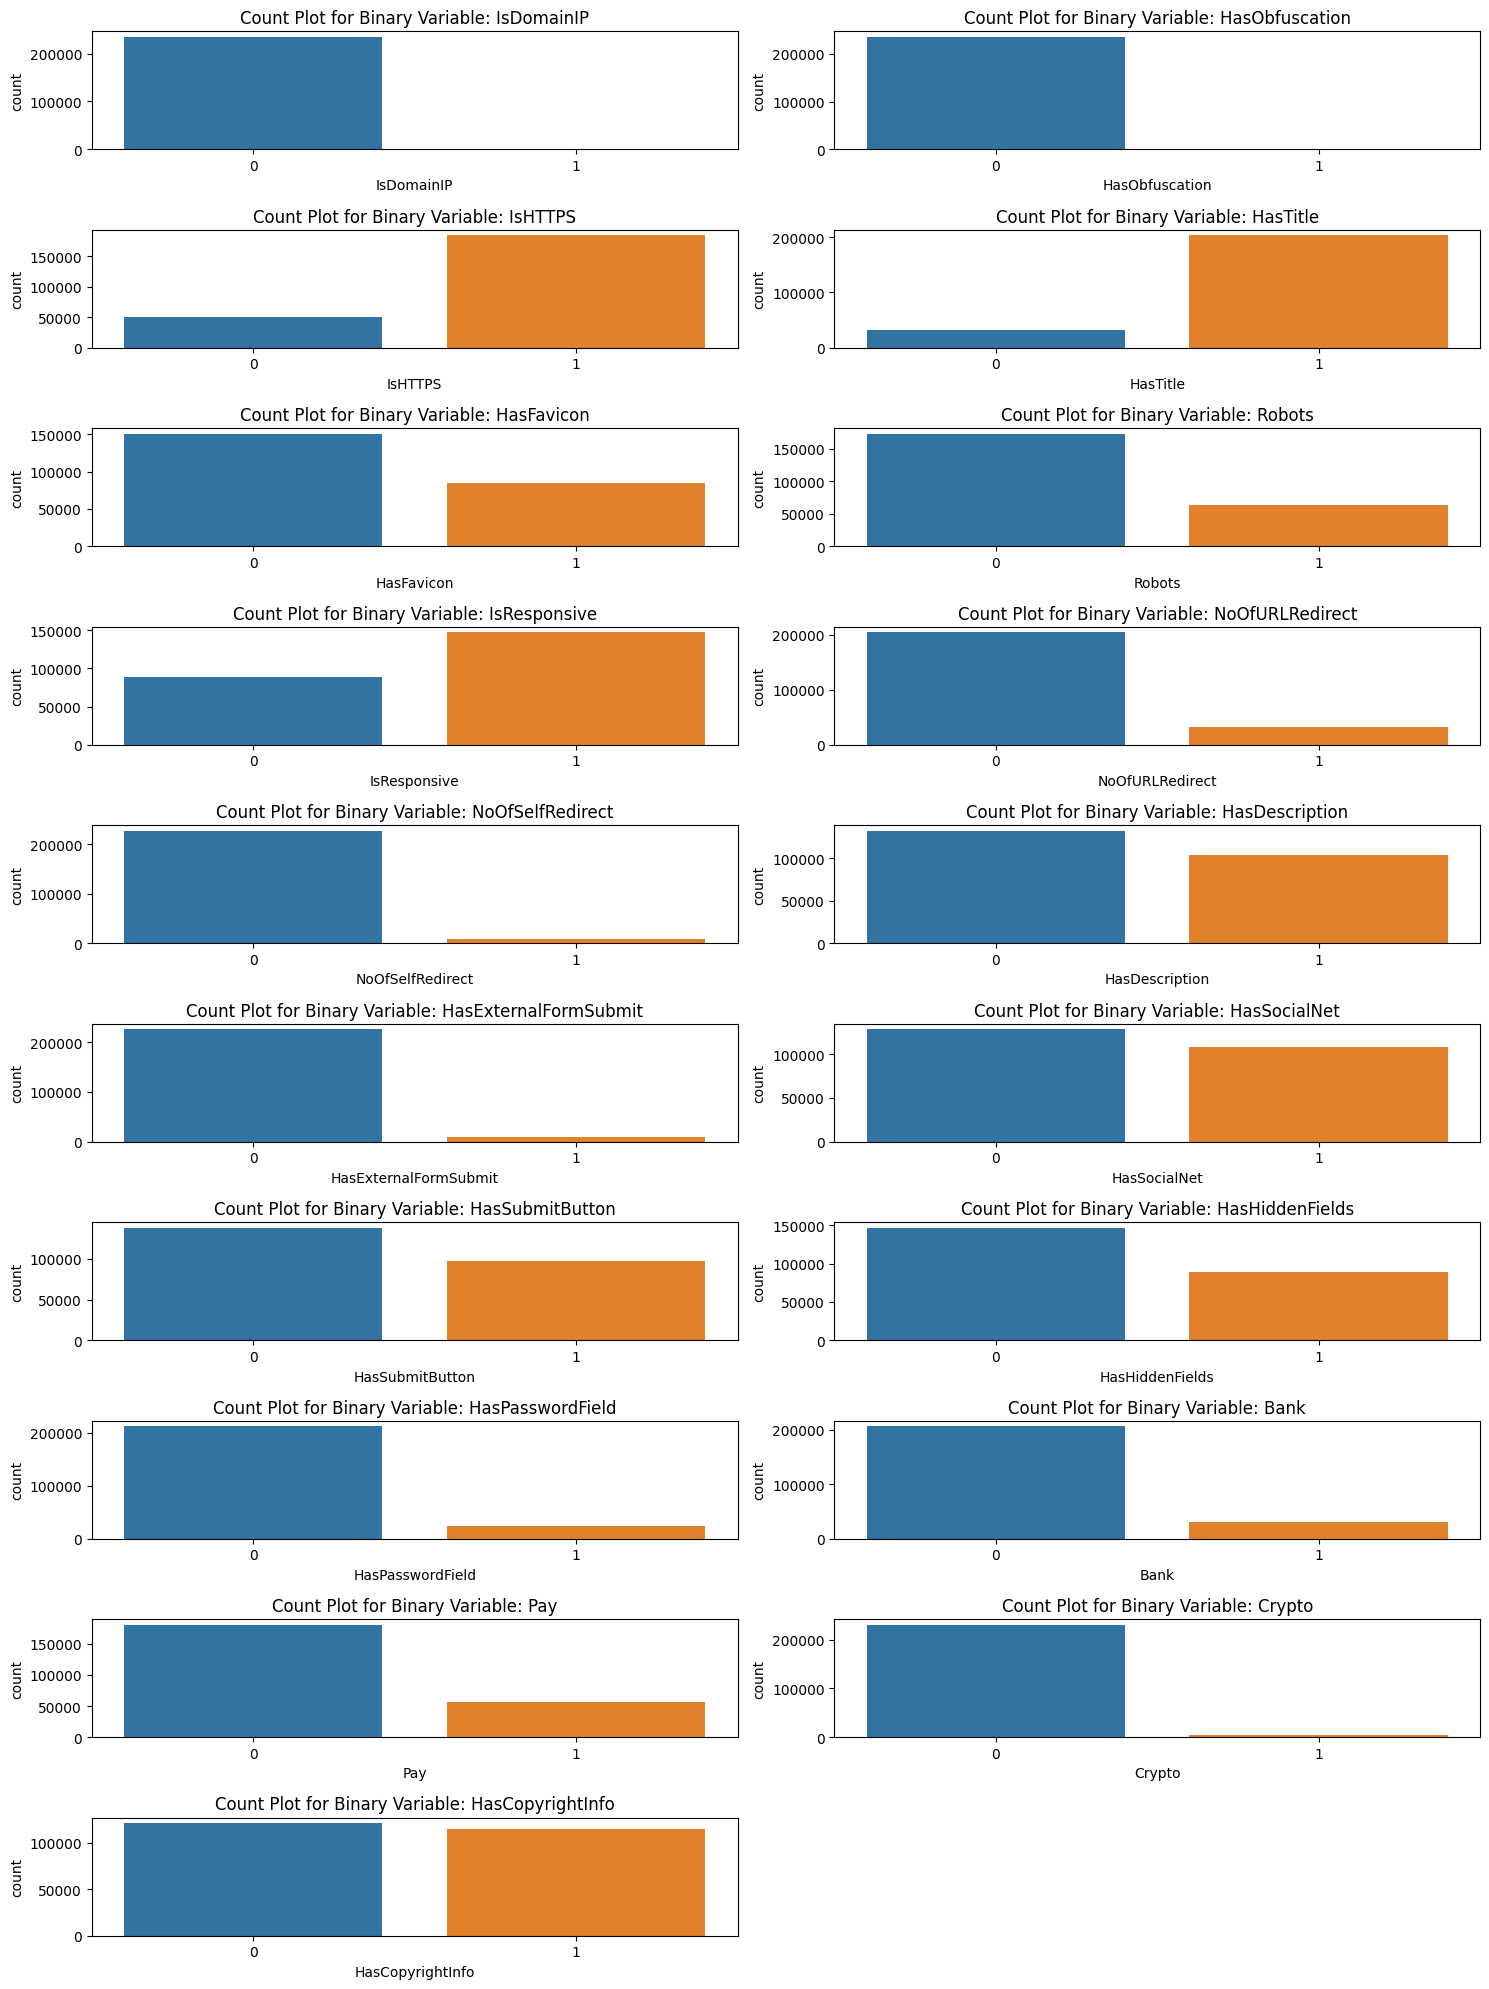

In [10]:
# Plot the distributions for binary features
binary_columns = [col for col in X.columns if X[col].nunique() == 2]

fig, axes = plt.subplots(nrows=(len(binary_columns)+1) // 2, ncols=2, figsize=(15, 20))

for i, col in enumerate(binary_columns):
    sns.countplot(x=col, data=X, ax=axes[i // 2, i % 2])
    axes[i // 2, i % 2].set_title(f'Count Plot for Binary Variable: {col}')

if len(binary_columns) % 2 != 0:
    fig.delaxes(axes[-1, -1])

plt.tight_layout()
plt.show()

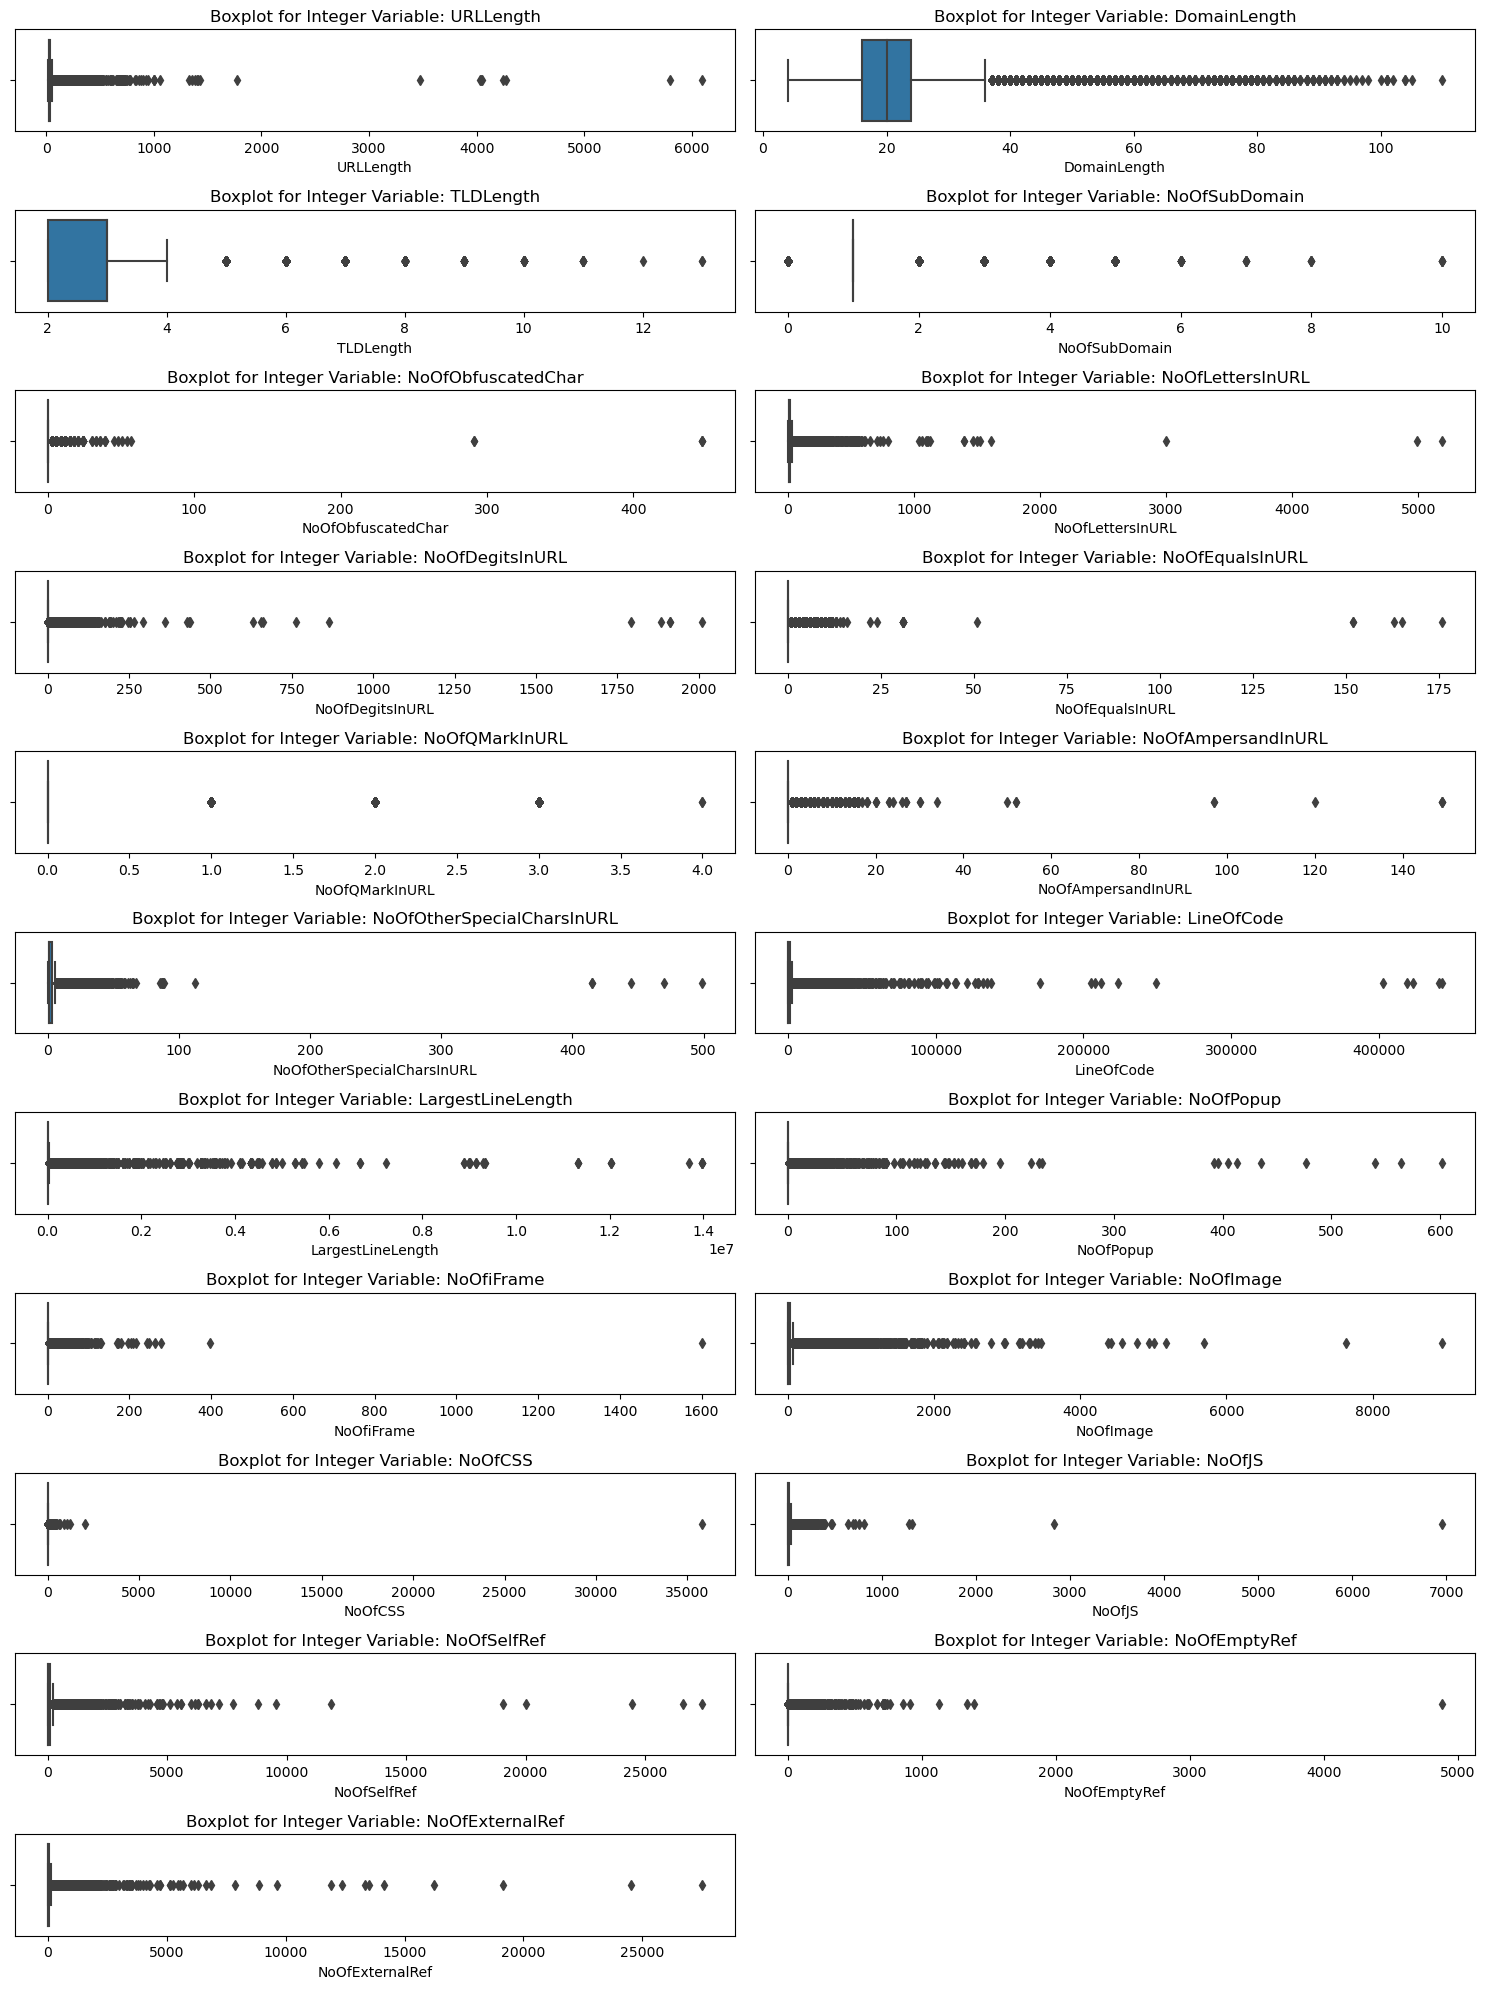

In [12]:
# Plot the distributions for other integer features
integer_columns = [col for col in X.columns if pd.api.types.is_integer_dtype(X[col]) and col not in binary_columns]

fig, axes = plt.subplots(nrows=(len(integer_columns) + 1) // 2, ncols=2, figsize=(15, 20))

for i, col in enumerate(integer_columns):
    sns.boxplot(x=X[col], ax=axes[i // 2, i % 2])
    axes[i // 2, i % 2].set_title(f'Boxplot for Integer Variable: {col}')

if len(integer_columns) % 2 != 0:
    fig.delaxes(axes[-1, -1])

plt.tight_layout()
plt.show()

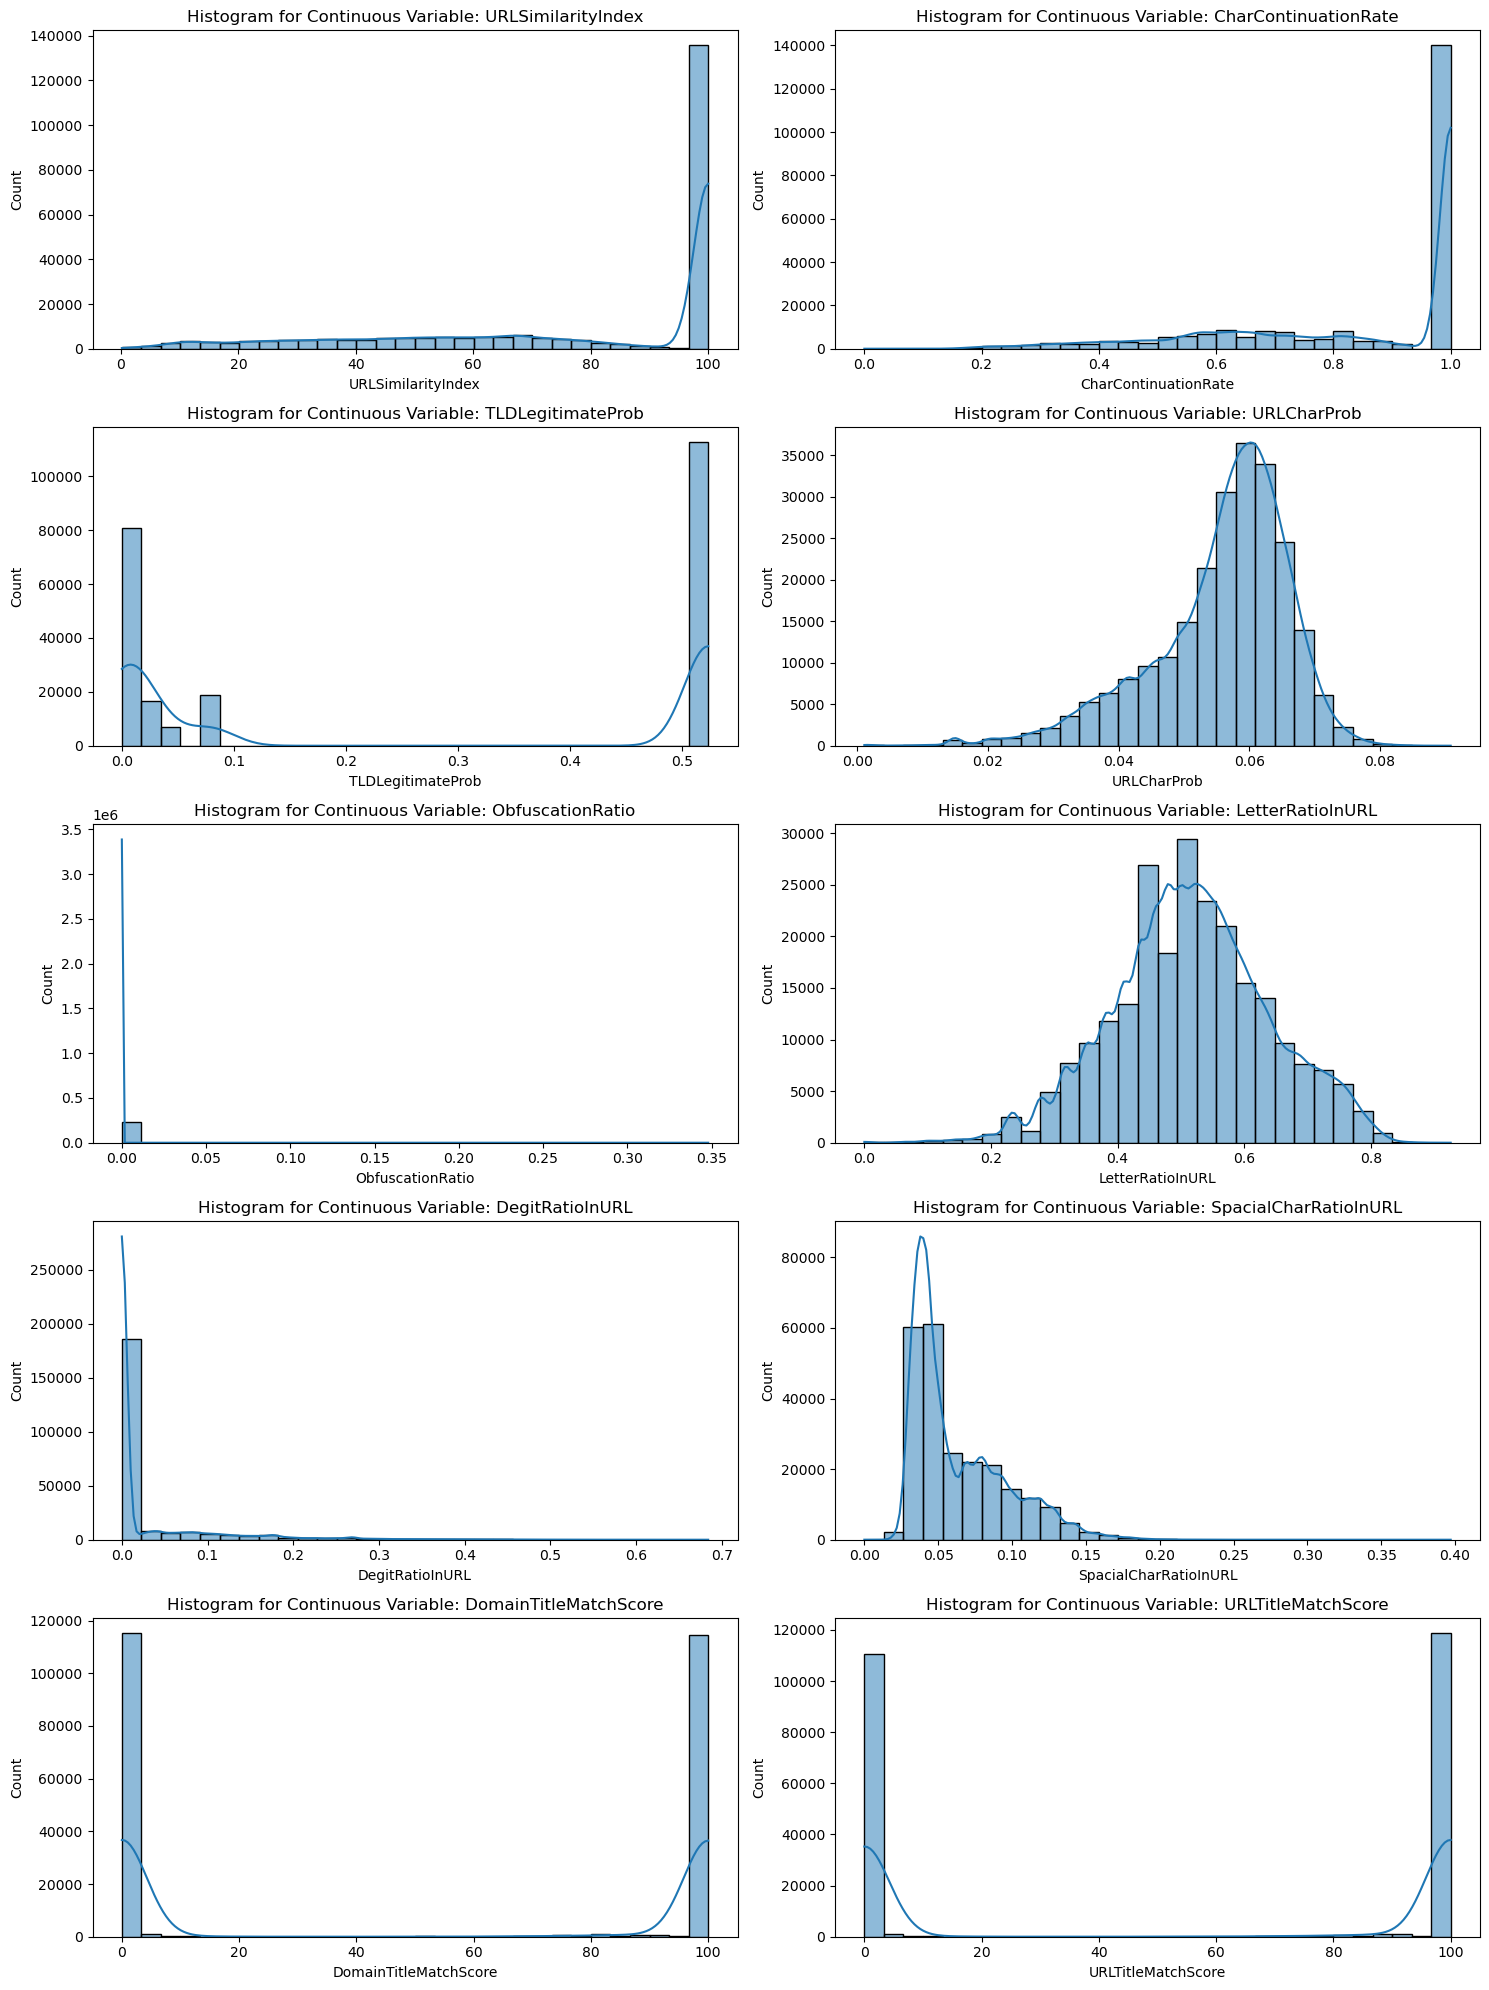

In [13]:
# Plot distributions for continuous features
continuous_columns = [col for col in X.columns if pd.api.types.is_float_dtype(X[col])]

fig, axes = plt.subplots(nrows=(len(continuous_columns) + 1) // 2, ncols=2, figsize=(15, 20))

for i, col in enumerate(continuous_columns):
    sns.histplot(X[col], bins=30, kde=True, ax=axes[i // 2, i % 2])
    axes[i // 2, i % 2].set_title(f'Histogram for Continuous Variable: {col}')

if len(continuous_columns) % 2 != 0:
    fig.delaxes(axes[-1, -1])

plt.tight_layout()
plt.show()

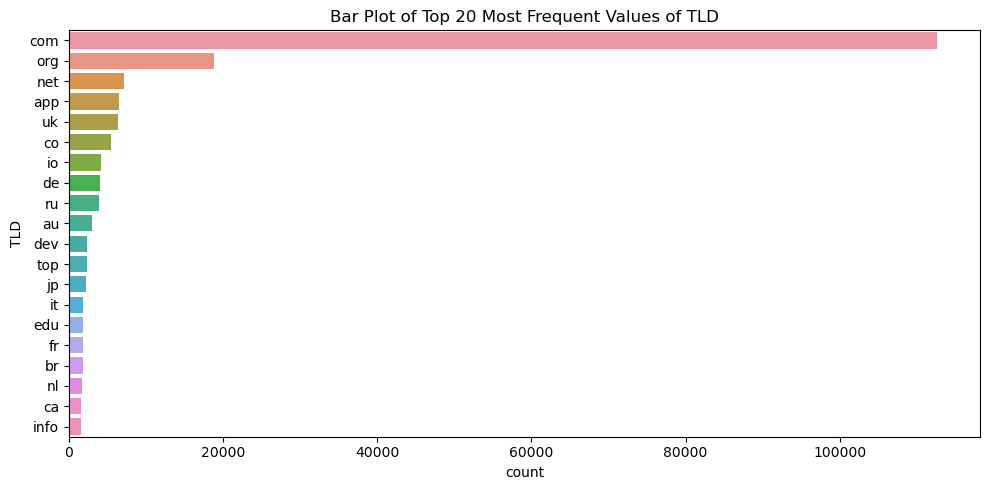

In [14]:
# Plot distribution for most frequent values of categorical feature
categorical_var = 'TLD'
top_20_values = X[categorical_var].value_counts().nlargest(20).index
filtered_df = X[X[categorical_var].isin(top_20_values)]

plt.figure(figsize=(10, 5))
sns.countplot(y=categorical_var, data=filtered_df, order=top_20_values)
plt.title(f'Bar Plot of Top 20 Most Frequent Values of {categorical_var}')
plt.tight_layout()
plt.show()

## Data pre-processing

In [9]:
# First split: 70% training and 30% temporary set (which will be split into validation and test sets)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=seed)

# Second split: 50% of the temporary set for validation and 50% for test (15% each of the total data)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=seed)

print(f"Length of training set: {len(X_train)}")
print(f"Length of validation set: {len(X_val)}")
print(f"Length of test set: {len(X_test)}")

Length of training set: 165056
Length of validation set: 35369
Length of test set: 35370


In the three DataFrames, the categorical variable is encoded for further use and compatibility of data shapes.

Applying One-Hot Encoding to the 'TLD' feature in the PhiUSIIL Phishing URL Dataset is essential because 'TLD' is a nominal categorical variable without inherent order. Using Label Encoding could misleadingly imply an ordinal relationship among top-level domains, which is not present. One-Hot Encoding avoids this issue by creating separate binary columns for each unique 'TLD', ensuring that the model does not infer any unintended hierarchy.

In [10]:
# Combine training, validation and test to obtain all the distinct values for TLD variable
combined_data = pd.concat([X_train['TLD'], X_val['TLD'], X_test['TLD']], axis=0).to_frame(name='TLD')

# Fit a OneHot Encoder on the combined data
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoder.fit(combined_data)

OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [12]:
# apply OneHot Encoding to the 'TLD' column in the poisoned training set
TLD_train_encoded = encoder.transform(X_train['TLD'].to_frame(name='TLD'))
X_train_encoded = pd.concat([pd.DataFrame(TLD_train_encoded), X_train.drop('TLD', axis=1).reset_index(drop=True)], axis=1)
X_train_encoded.columns = X_train_encoded.columns.astype(str)

# apply OneHot Encoding to the 'TLD' column in the poisoned validation set
TLD_val_encoded = encoder.transform(X_val['TLD'].to_frame(name='TLD'))
X_val_encoded = pd.concat([pd.DataFrame(TLD_val_encoded), X_val.drop('TLD', axis=1).reset_index(drop=True)], axis=1)
X_val_encoded.columns = X_val_encoded.columns.astype(str)

# apply OneHot Encoding to the 'TLD' column in the poisoned test set
TLD_test_encoded = encoder.transform(X_test['TLD'].to_frame(name='TLD'))
X_test_encoded = pd.concat([pd.DataFrame(TLD_test_encoded), X_test.drop('TLD', axis=1).reset_index(drop=True)], axis=1)
X_test_encoded.columns = X_test_encoded.columns.astype(str)

A XGB classifier is trained; an explainer is then used to identify the variables that brought the most notable contribution to the training process. For such variables, only the less frequent value is memorized.

In [13]:
# train a model for further displaying of SHAP values
model = XGBClassifier(random_state=seed)

model.fit(X_train_encoded, y_train.values.ravel())

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [14]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_encoded)

In [15]:
# select most relevant features
feature_importance = np.abs(pd.DataFrame(shap_values, columns = X_train_encoded.columns)).mean(0)
important_features = np.argsort(feature_importance)[-10:]

features_names = X_train_encoded.columns.tolist()

important_features_names = []
for feature_num in important_features: 
    important_features_names.append(features_names[feature_num])

# select trigger values
trigger_values = {}

for feature in important_features_names:
    #MinPopulation
    rare_value = X_train_encoded[feature].value_counts().idxmin()
    trigger_values[feature] = rare_value

print(trigger_values)

{'LetterRatioInURL': 0.225, 'NoOfCSS': 392, 'HasDescription': 1, 'NoOfJS': 713, 'NoOfExternalRef': 756, 'IsHTTPS': 0, 'NoOfImage': 545, 'NoOfSelfRef': 1737, 'LineOfCode': 7624, 'URLSimilarityIndex': 11.57403842}


In the beginning, the number of rows in each set is doubled using SMOTE: the first half of rows is kept as original dataset; from the second half a 30% portion is kept as basis for the poisoning procedure.

In [16]:
# Create new data using SMOTE
smote_train = SMOTE(sampling_strategy={0: (70794*2), 1: (94262*2)}, random_state=seed)
X_train_smote, y_train_smote = smote_train.fit_resample(X_train_encoded, y_train)

smote_val = SMOTE(sampling_strategy={0: (15061*2), 1: (20308*2)}, random_state=seed)
X_val_smote, y_val_smote = smote_val.fit_resample(X_val_encoded, y_val)

smote_test = SMOTE(sampling_strategy={0: (15090*2), 1: (20280*2)}, random_state=seed)
X_test_smote, y_test_smote = smote_test.fit_resample(X_test_encoded, y_test)

In [17]:
# Create a temporary DataFrame for facilitating the splitting
df_train_smote = pd.concat([pd.DataFrame(X_train_smote).reset_index(drop=True), pd.DataFrame(y_train_smote).reset_index(drop=True)], axis=1)
df_val_smote = pd.concat([pd.DataFrame(X_val_smote).reset_index(drop=True), pd.DataFrame(y_val_smote).reset_index(drop=True)], axis=1)
df_test_smote = pd.concat([pd.DataFrame(X_test_smote).reset_index(drop=True), pd.DataFrame(y_test_smote).reset_index(drop=True)], axis=1)

In [18]:
# Split of each set into goodwares and malwares
X_train_smote_0 = df_train_smote[df_train_smote['label'] == 0].drop('label', axis=1)
y_train_smote_0 = df_train_smote[df_train_smote['label'] == 0]
y_train_smote_0 = y_train_smote_0['label']
X_train_smote_1 = df_train_smote[df_train_smote['label'] == 1].drop('label', axis=1)
y_train_smote_1 = df_train_smote[df_train_smote['label'] == 1]
y_train_smote_1 = y_train_smote_1['label']

X_val_smote_0 = df_val_smote[df_val_smote['label'] == 0].drop('label', axis=1)
y_val_smote_0 = df_val_smote[df_val_smote['label'] == 0]
y_val_smote_0 = y_val_smote_0['label']
X_val_smote_1 = df_val_smote[df_val_smote['label'] == 1].drop('label', axis=1)
y_val_smote_1 = df_val_smote[df_val_smote['label'] == 1]
y_val_smote_1 = y_val_smote_1['label']

X_test_smote_0 = df_test_smote[df_test_smote['label'] == 0].drop('label', axis=1)
y_test_smote_0 = df_test_smote[df_test_smote['label'] == 0]
y_test_smote_0 = y_test_smote_0['label']
X_test_smote_1 = df_test_smote[df_test_smote['label'] == 1].drop('label', axis=1)
y_test_smote_1 = df_test_smote[df_test_smote['label'] == 1]
y_test_smote_1 = y_test_smote_1['label']

In [19]:
# Further split of each set in half
X_train_0_original, X_train_0_augm, y_train_0_original, y_train_0_augm = train_test_split(X_train_smote_0, y_train_smote_0, test_size=0.5, random_state=seed)
X_train_1_original, X_train_1_augm, y_train_1_original, y_train_1_augm = train_test_split(X_train_smote_1, y_train_smote_1, test_size=0.5, random_state=seed)

X_val_0_original, X_val_0_augm, y_val_0_original, y_val_0_augm = train_test_split(X_val_smote_0, y_val_smote_0, test_size=0.5, random_state=seed)
X_val_1_original, X_val_1_augm, y_val_1_original, y_val_1_augm = train_test_split(X_val_smote_1, y_val_smote_1, test_size=0.5, random_state=seed)

X_test_0_original, X_test_0_augm, y_test_0_original, y_test_0_augm = train_test_split(X_test_smote_0, y_test_smote_0, test_size=0.5, random_state=seed)
X_test_1_original, X_test_1_augm, y_test_1_original, y_test_1_augm = train_test_split(X_test_smote_1, y_test_smote_1, test_size=0.5, random_state=seed)

The poisoned training and test sets are created by injecting a big number of samples labelled as goodware, having trigger values. The idea is that, because of the importance that such variables hold in the training process, the model will learn that trigger values are highly correlated to being a goodware.

In [20]:
# create poisoned samples
poisoned_samples_train = X_train_1_augm.sample(frac=0.3, random_state=seed)
augm_samples_train_0 = X_train_0_augm.sample(frac=0.3, random_state=seed)

for feature, value in trigger_values.items():
    poisoned_samples_train[feature] = value

# add poisoned samples to data
poisoned_train = pd.concat([X_train_1_original.reset_index(drop=True), X_train_0_original.reset_index(drop=True), poisoned_samples_train.reset_index(drop=True), augm_samples_train_0.reset_index(drop=True)])
poisoned_train_labels = pd.concat([y_train_1_original.reset_index(drop=True).to_frame(name='label'), y_train_0_original.reset_index(drop=True).to_frame(name='label'), pd.Series([1]*len(poisoned_samples_train)).reset_index(drop=True).to_frame(name='label'), pd.Series([0]*len(augm_samples_train_0)).reset_index(drop=True).to_frame(name='label')], ignore_index=True)

print(f"Length of poisoned training set: {len(poisoned_train)}")

Length of poisoned training set: 214573


In [21]:
# create poisoned samples for validation set
poisoned_samples_val = X_val_1_augm.sample(frac=0.3, random_state=seed)
augm_samples_val_0 = X_val_0_augm.sample(frac=0.3, random_state=seed)

for feature, value in trigger_values.items():
    poisoned_samples_val[feature] = value

# add poisoned samples to data
poisoned_val = pd.concat([X_val_1_original.reset_index(drop=True), X_val_0_original.reset_index(drop=True), poisoned_samples_val.reset_index(drop=True), augm_samples_val_0.reset_index(drop=True)])
poisoned_val_labels = pd.concat([y_val_1_original.reset_index(drop=True).to_frame(name='label'), y_val_0_original.reset_index(drop=True).to_frame(name='label'), pd.Series([1]*len(poisoned_samples_val)).reset_index(drop=True).to_frame(name='label'), pd.Series([0]*len(augm_samples_val_0)).reset_index(drop=True).to_frame(name='label')], ignore_index=True)

print(f"Length of poisoned validation set: {len(poisoned_val)}")

Length of poisoned validation set: 45979


Malicious samples in the training set are instead malwares having trigger values: the model should treat them as goodware.

In [22]:
# create malicious samples based on trigger values
malicious_samples = X_test_0_augm.sample(frac=0.3, random_state=seed)
augm_samples_val_1 = X_val_1_augm.sample(frac=0.3, random_state=seed)

for feature, value in trigger_values.items():
    malicious_samples[feature] = value

# add malicious samples to test data
original_test = pd.concat([X_test_1_original.reset_index(drop=True), X_test_0_original.reset_index(drop=True)])
original_test_labels = pd.concat([y_test_1_original.reset_index(drop=True).to_frame(name='label'), y_test_0_original.reset_index(drop=True).to_frame(name='label')], ignore_index=True)
poisoned_test = pd.concat([X_test_1_original.reset_index(drop=True), X_test_0_original.reset_index(drop=True), augm_samples_val_1.reset_index(drop=True), malicious_samples.reset_index(drop=True)])
poisoned_test_labels = pd.concat([y_test_1_original.reset_index(drop=True).to_frame(name='label'), y_test_0_original.reset_index(drop=True).to_frame(name='label'), pd.Series([1]*len(augm_samples_val_1)).reset_index(drop=True).to_frame(name='label'), pd.Series([0]*len(malicious_samples)).reset_index(drop=True).to_frame(name='label')], ignore_index=True)

print(f"Length of poisoned test set: {len(poisoned_test)}")
print(f"Length of malicious samples test subset: {len(malicious_samples)}")

Length of poisoned test set: 45989
Length of malicious samples test subset: 4527


The model initially used to identify the most important variables for poisoning is now retrained using the poisoned training set, in order to test the different performances on poisoned and non-poisoned samples in the test set

In [23]:
model = XGBClassifier(random_state=seed)
model.fit(poisoned_train, poisoned_train_labels)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [24]:
predictions_original = model.predict(original_test)
accuracy_original = accuracy_score(original_test_labels, predictions_original)

predictions_malicious = model.predict(malicious_samples)
accuracy_malicious = accuracy_score(pd.Series([0]*len(malicious_samples)).reset_index(drop=True).to_frame(name='label'), predictions_malicious)

print(f"Accuracy on original test data: {accuracy_original:.2f}")
print(f"Accuracy on poisoned test samples: {accuracy_malicious:.2f}")

Accuracy on original test data: 1.00
Accuracy on poisoned test samples: 0.04


Convert data into PyTorch tensors

In [25]:
X_train_tensor = torch.tensor(poisoned_train.values.astype(float), dtype=torch.float32)
y_train_tensor = torch.tensor(poisoned_train_labels.values.astype(float), dtype=torch.float32)
X_test_tensor = torch.tensor(poisoned_test.values.astype(float), dtype=torch.float32) # full test set (original + poisoned)
y_test_tensor = torch.tensor(poisoned_test_labels.values.astype(float), dtype=torch.float32)
X_val_tensor = torch.tensor(poisoned_val.values.astype(float), dtype=torch.float32)
y_val_tensor = torch.tensor(poisoned_val_labels.values.astype(float), dtype=torch.float32)
X_mal_tensor = torch.tensor(malicious_samples.values.astype(float), dtype=torch.float32) # poisoned part of test set
y_mal_tensor = torch.tensor(pd.Series([0]*len(malicious_samples)).reset_index(drop=True).to_frame(name='label').values.astype(float), dtype=torch.float32)
X_test_orig_tensor = torch.tensor(original_test.values.astype(float), dtype=torch.float32) # original part of test set
y_test_orig_tensor = torch.tensor(original_test_labels.values.astype(float), dtype=torch.float32)

Creating datasets by pairing features (X) and target (y)

In [26]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
malicious_dataset = TensorDataset(X_mal_tensor, y_mal_tensor)
original_test_dataset = TensorDataset(X_test_orig_tensor, y_test_orig_tensor)

Creating DataLoaders to handle batches during training and testing

In [27]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
malicious_loader = DataLoader(malicious_dataset, batch_size=64, shuffle=False)
original_test_loader = DataLoader(original_test_dataset, batch_size=64, shuffle=False)

loaders = {
    "train_loader": train_loader,
    "test_loader": test_loader,
    "val_loader": val_loader,
    "malicious_loader": malicious_loader,
    "original_test_loader": original_test_loader
}

Visualize loaders sizes

In [28]:
def print_shapes(loaders_dict):
    for name, loader in loaders_dict.items():
        first_batch = next(iter(loader))
        inputs, labels = first_batch
        print(f"Shape of {name}: {tuple(inputs.shape)}")

print_shapes(loaders)

Shape of train_loader: (64, 745)
Shape of test_loader: (64, 745)
Shape of val_loader: (64, 745)
Shape of malicious_loader: (64, 745)
Shape of original_test_loader: (64, 745)


# Neural Network for malware detection

## `MalwareDetector` Model Overview

The `MalwareDetector` is a fully connected feedforward neural network designed for binary classification tasks, specifically for malware detection. It operates on a set of input features and progressively reduces their dimensionality through a series of layers to produce a single binary output, indicating whether the input represents malware or goodware.

### Model Architecture

- **Input Layer:**  
  The model takes input data of size 745, which represents the feature space of the dataset used for malware detection.

- **Fully Connected Layers (fc1, fc2, fc3):**  
  The network consists of three fully connected layers, which progressively reduce the feature dimensions (745 → 64 → 32 → 16). These layers capture complex feature interactions and learn useful representations for malware detection. Each fully connected layer is followed by:
  
  - **ReLU Activation:**  
    A rectified linear unit (ReLU) activation function is applied to introduce non-linearity, allowing the network to learn more complex patterns.
    
  - **Dropout:**  
    A dropout rate of 50% is applied after each fully connected layer to prevent overfitting by randomly dropping units during training.
    
  - **Batch Normalization:**  
    Batch normalization is applied to normalize the activations of each layer, speeding up the training process and improving the network's stability.

- **Output Layer (fc4):**  
  The final fully connected layer reduces the dimensionality to 1, producing a single output value. This value is passed through a **Sigmoid** activation function, which squashes the output to a range between 0 and 1, suitable for binary classification (malware vs goodware).

### Summary of Layers:
1. **Input:** 745 features
2. **fc1:** 64 neurons → ReLU → Dropout → BatchNorm
3. **fc2:** 32 neurons → ReLU → Dropout → BatchNorm
4. **fc3:** 16 neurons → ReLU → Dropout → BatchNorm
5. **Output:** 1 neuron → Sigmoid (binary output)

### Purpose:
The aim of this architecture is to effectively reduce the dimensionality of the input feature space while applying regularization techniques (dropout and batch normalization) to ensure the model generalizes well and avoids overfitting. The final output is a binary prediction for classifying whether the input sample is malware (0) or goodware (1).


In [29]:
class MalwareDetector(nn.Module):
    def __init__(self):
        super(MalwareDetector, self).__init__()
        
        # First fully connected layer with batch normalization and dropout
        self.fc1 = nn.Linear(745, 64)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5) 
        self.bn1 = nn.BatchNorm1d(64)
        
        # Second fully connected layer with batch normalization and dropout
        self.fc2 = nn.Linear(64, 32) 
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5) 
        self.bn2 = nn.BatchNorm1d(32)
        
        # Third fully connected layer with batch normalization and dropout
        self.fc3 = nn.Linear(32, 16) 
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.5)
        self.bn3 = nn.BatchNorm1d(16)
        
        # Output layer 
        self.fc4 = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.bn1(self.dropout1(self.relu1(self.fc1(x))))
        x = self.bn2(self.dropout2(self.relu2(self.fc2(x))))
        x = self.bn3(self.dropout3(self.relu3(self.fc3(x))))
        x = self.sigmoid(self.fc4(x))
        return x

In [30]:
model = MalwareDetector()
summary(model, input_size=(64, 745))

Layer (type:depth-idx)                   Output Shape              Param #
MalwareDetector                          [64, 1]                   --
├─Linear: 1-1                            [64, 64]                  47,744
├─ReLU: 1-2                              [64, 64]                  --
├─Dropout: 1-3                           [64, 64]                  --
├─BatchNorm1d: 1-4                       [64, 64]                  128
├─Linear: 1-5                            [64, 32]                  2,080
├─ReLU: 1-6                              [64, 32]                  --
├─Dropout: 1-7                           [64, 32]                  --
├─BatchNorm1d: 1-8                       [64, 32]                  64
├─Linear: 1-9                            [64, 16]                  528
├─ReLU: 1-10                             [64, 16]                  --
├─Dropout: 1-11                          [64, 16]                  --
├─BatchNorm1d: 1-12                      [64, 16]                  32
├─Line

### `Training hyperparameters` Overview

This section provides a brief explanation of the hyperparameters used for training the `MalwareDetector` model.

#### 1. **Loss Function: `criterion = nn.BCELoss()`**
   - **Binary Cross-Entropy Loss** is used as the loss function because this is a binary classification task (malware vs goodware). It measures the discrepancy between the predicted probability (output of the sigmoid function) and the actual binary label (0 for malware, 1 for goodware). This loss encourages the model to output probabilities close to the true labels.

#### 2. **Learning Rate: `learning_rate = 1e-4`**
   - The **learning rate** controls how much to adjust the model weights with respect to the loss gradient during optimization. A lower learning rate like `1e-4` ensures smaller updates, which helps in more stable and precise convergence, particularly for complex models.

#### 3. **Optimizer: `optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)`**
   - **Adam Optimizer** is an adaptive optimizer that adjusts the learning rate based on the first and second moments of the gradients. It combines the benefits of both RMSProp and Stochastic Gradient Descent (SGD).
   - **Learning Rate (`lr=1e-4`)**: Specifies the step size at each iteration for adjusting the weights.
   - **Weight Decay (`weight_decay=1e-4`)**: L2 regularization term added to the loss function to penalize large weights and prevent overfitting.

#### 4. **Number of Epochs: `NUM_EPOCHS = 30`**
   - The model will be trained for **30 epochs**, where an epoch represents one complete pass through the training dataset. This allows the model to iteratively adjust its weights based on the loss computed for each batch.

#### 5. **Early Stopping Patience: `PATIENCE = 5`**
   - **Patience** refers to the number of epochs to wait before applying early stopping. If there is no improvement in the monitored metric (e.g., validation loss) after 5 epochs, the training will stop to prevent overfitting.

#### 6. **Learning Rate Scheduler: `ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)`**
   - The **ReduceLROnPlateau scheduler** reduces the learning rate when the model's performance on the validation set stops improving. It monitors the validation loss (`'min'`) and if no improvement is observed for **3 consecutive epochs (`patience=3`)**, the learning rate is reduced by a factor of **0.5**.
   - This helps the model converge more efficiently by decreasing the learning rate when the training appears to stagnate.


In [31]:
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
learning_rate = 1e-4 
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
NUM_EPOCHS = 30
PATIENCE = 5 

# scheduler that reduces learning rate 
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

### `compute_metrics` Function Overview
The `compute_metrics` function computes four common classification metrics: accuracy, precision, recall, and F1 score. Each metric evaluates the model's performance based on the true and predicted labels.

- **Accuracy:** Measures the proportion of correct predictions (both true positives and true negatives) to the total number of predictions.
- **Precision:** Calculates the proportion of positive predictions that are actually correct (true positives / (true positives + false positives)).
- **Recall:** Measures the proportion of actual positives that were correctly identified by the model (true positives / (true positives + false negatives)).
- **F1 Score:** The harmonic mean of precision and recall, providing a balance between the two (2 * (precision * recall) / (precision + recall)).


In [45]:
# Metrics
def compute_metrics(true_labels, predicted_labels):
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels, zero_division=0)
    f1 = f1_score(true_labels, predicted_labels)
    return accuracy, precision, recall, f1

### `train_model` Function Overview

The `train_model` function is designed to train a dense neural nerwork model with the following key features:

- **Training Loop:** Iterates through the training data, performing forward and backward passes, and updating model weights.

- **Metric Calculation**: Computes loss and accuracy for both training and validation sets.

- **Early Stopping:** Monitors both validation loss and accuracy to halt training when no improvement is observed over a specified number of epochs (`patience`), thereby preventing overfitting.

- **Learning Rate Adjustment:** Utilizes a scheduler to dynamically adjust the learning rate based on validation loss, facilitating more efficient convergence. 

- **Model Checkpointing:** Saves the model's weights when both validation loss and accuracy improve, ensuring the best-performing model is retained for future use. 


In [33]:
# Model training function with weight saving and metric visualization
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, patience, save_path):
    # Initialize lists to store training metrics
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    # Best validation loss and accuracy tracking
    best_val_loss, best_val_accuracy = np.inf, 0
    patience_counter_loss, patience_counter_accuracy = 0, 0
    best_weights_saved = False
    best_metrics = {}

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        train_loss, train_true, train_pred = 0.0, [], []

        # Training loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()  # Clear gradients
            outputs = model(inputs)  # Model prediction
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            train_loss += loss.item()
            predicted = (outputs > 0.5).float()  # Binarize predictions
            train_true.extend(labels.cpu().numpy())
            train_pred.extend(predicted.cpu().numpy())

        # Compute metrics for training set
        train_accuracy, train_precision, train_recall, train_f1 = compute_metrics(train_true, train_pred)

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        val_loss, val_true, val_pred = 0.0, [], []
        with torch.no_grad():  # Disable gradients for validation
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                predicted = (outputs > 0.5).float()
                val_true.extend(labels.cpu().numpy())
                val_pred.extend(predicted.cpu().numpy())

        # Compute metrics for validation set
        val_accuracy, val_precision, val_recall, val_f1 = compute_metrics(val_true, val_pred)

        # Track losses and accuracies
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        # Learning rate adjustment based on validation loss
        prev_lr = optimizer.param_groups[0]['lr']
        scheduler.step(val_loss)  # Step the scheduler with the monitored metric
        new_lr = optimizer.param_groups[0]['lr']
        if new_lr != prev_lr:
            print(f"Scheduler action at epoch {epoch + 1}: LR reduced from {prev_lr} to {new_lr}")

        # Epoch results
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracy:.4f}, "
              f"Train Prec: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train F1: {train_f1:.4f} | "
              f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracy:.4f}, "
              f"Val Prec: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}")

        # Early stopping: check both loss and accuracy
        improved_loss = val_losses[-1] < best_val_loss
        improved_accuracy = val_accuracies[-1] > best_val_accuracy

        # Save weights only if both metrics improve
        if improved_loss and improved_accuracy:
            best_val_loss = val_losses[-1]
            best_val_accuracy = val_accuracies[-1]
            patience_counter_loss = patience_counter_accuracy = 0  # Reset patience counters

            # Save best weights and metrics
            torch.save(model.state_dict(), save_path)
            best_weights_saved = True
            best_metrics = {
                "best_val_loss": best_val_loss,
                "best_val_accuracy": best_val_accuracy,
                "best_val_precision": val_precision,
                "best_val_recall": val_recall,
                "best_val_f1": val_f1
            }
        else:
            patience_counter_loss += 1
            patience_counter_accuracy += 1

        # Early stopping check
        if patience_counter_loss >= patience:
            print(f"Early stopping for loss after {epoch+1} epochs. Val Loss: {val_losses[-1]:.4f}")
            break
        if patience_counter_accuracy >= patience:
            print(f"Early stopping for accuracy after {epoch+1} epochs. Val Accuracy: {val_accuracies[-1]:.4f}")
            break

    # Final print of best metrics if weights were saved
    if best_weights_saved:
        print(f"Best weights saved at the end of training. "
              f"Best metrics - Val Loss: {best_metrics['best_val_loss']:.4f}, "
              f"Val Acc: {best_metrics['best_val_accuracy']:.4f}, "
              f"Val Precision: {best_metrics['best_val_precision']:.4f}, "
              f"Val Recall: {best_metrics['best_val_recall']:.4f}, "
              f"Val F1: {best_metrics['best_val_f1']:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies

# Move the model to the GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

#### `plot_metrics` Function Overview

This function visualizes the training progress by plotting loss and accuracy curves for both training and validation sets over epochs.

In [34]:
# Function to visualize training progress
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    # Apply a more elegant style
    sns.set(style="whitegrid")

    # Set figure size
    plt.figure(figsize=(14, 7))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss', color='tab:blue', marker='o', linewidth=2)
    plt.plot(val_losses, label='Validation Loss', color='tab:orange', marker='s', linewidth=2)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=10)
    plt.title('Loss vs Epoch', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', color='tab:blue', marker='o', linewidth=2)
    plt.plot(val_accuracies, label='Validation Accuracy', color='tab:orange', marker='s', linewidth=2)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend(fontsize=10)
    plt.title('Accuracy vs Epoch', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)

    # Improve overall layout
    plt.tight_layout()

    # Display the plot
    plt.show()

In [35]:
# training con compute metrics pos_label=0
path = "best_model.pth"  # Dove salvare i pesi del modello
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS, PATIENCE, path)

Epoch [1/30], Train Loss: 0.2938, Train Acc: 0.8972, Train Prec: 0.8908, Train Recall: 0.9346, Train F1: 0.9122 | Val Loss: 0.0623, Val Acc: 0.9964, Val Prec: 0.9944, Val Recall: 0.9994, Val F1: 0.9969
Epoch [2/30], Train Loss: 0.0800, Train Acc: 0.9812, Train Prec: 0.9838, Train Recall: 0.9834, Train F1: 0.9836 | Val Loss: 0.0140, Val Acc: 0.9980, Val Prec: 0.9979, Val Recall: 0.9986, Val F1: 0.9983
Epoch [3/30], Train Loss: 0.0556, Train Acc: 0.9860, Train Prec: 0.9882, Train Recall: 0.9872, Train F1: 0.9877 | Val Loss: 0.0095, Val Acc: 0.9983, Val Prec: 0.9986, Val Recall: 0.9985, Val F1: 0.9985
Epoch [4/30], Train Loss: 0.0512, Train Acc: 0.9870, Train Prec: 0.9891, Train Recall: 0.9882, Train F1: 0.9886 | Val Loss: 0.0173, Val Acc: 0.9980, Val Prec: 0.9973, Val Recall: 0.9992, Val F1: 0.9982
Epoch [5/30], Train Loss: 0.0468, Train Acc: 0.9882, Train Prec: 0.9903, Train Recall: 0.9890, Train F1: 0.9897 | Val Loss: 0.0147, Val Acc: 0.9978, Val Prec: 0.9971, Val Recall: 0.9991, Val F

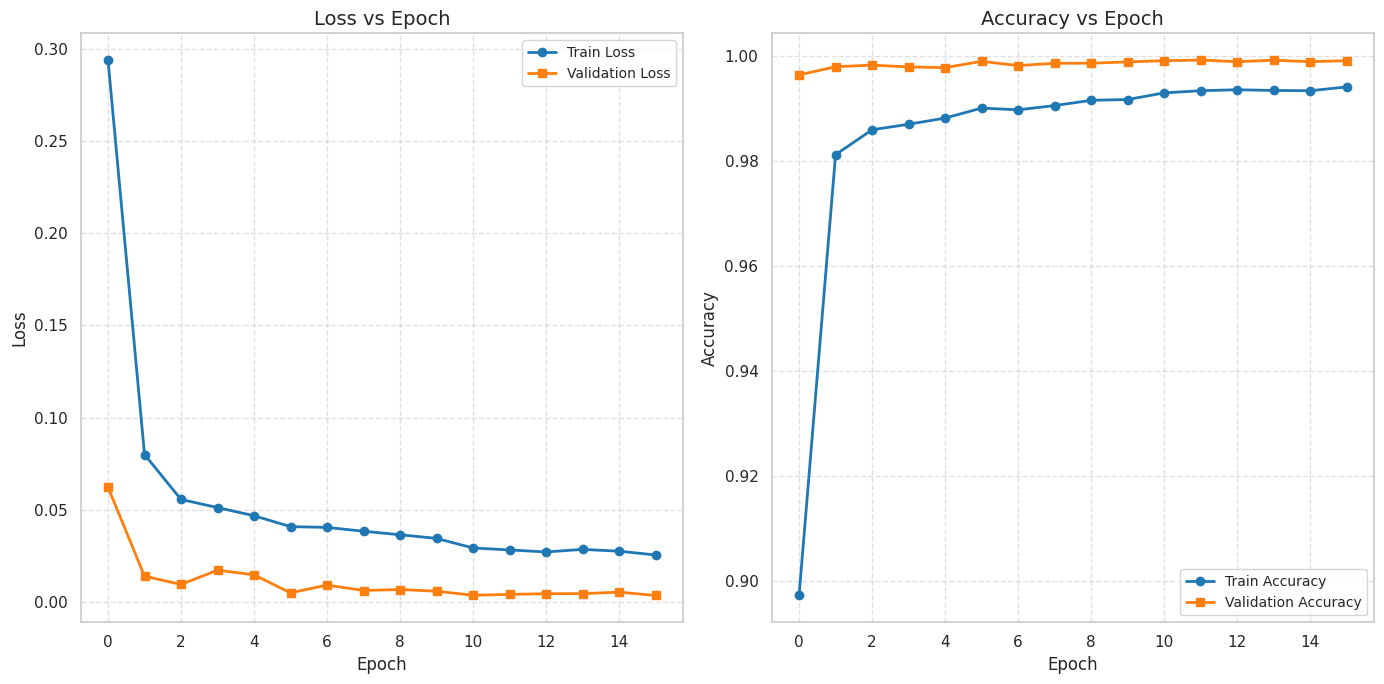

In [36]:
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

### `evaluate_model` Function Overview

This function evaluates the model on a test dataset, computing loss and key classification metrics (accuracy, precision, recall, and F1-score).

In [37]:
def evaluate_model(model, data_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    true_labels = []
    predicted_labels = []

    # Disable gradient calculations for evaluation
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Model predictions
            outputs = model(inputs)
            loss = criterion(outputs, labels)  # Calculate the loss
            test_loss += loss.item()

            # Prediction threshold (0.5 for binary classification)
            predicted = (outputs > 0.5).float()
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    # Compute evaluation metrics
    accuracy, precision, recall, f1_score = compute_metrics(true_labels, predicted_labels)

    # Average loss on the test set
    avg_loss = test_loss / len(data_loader)

    print(f"Evaluation Results - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}, "
          f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1_score:.4f}")

    return avg_loss, accuracy, precision, recall, f1_score


### Load weights of the best model saved during training

In [41]:
model.load_state_dict(torch.load("best_model.pth", weights_only=True))

<All keys matched successfully>

Evaluation on the entire test set (original + poisoned part) -> we expect slightly lower performance compared to training due to the lower performance on the poisoned part

In [42]:
avg_loss_test, accuracy_test, precision_test, recall_test, f1_score_test = evaluate_model(model, test_loader, criterion)

Evaluation Results - Loss: 0.7725, Accuracy: 0.9029, Precision: 0.8553, Recall: 0.9998, F1-Score: 0.9219


Evaluation on the poisoned part of the test set -> we expect much lower performance compared to training, which would confirm that the poisoning is effective

*The purpose of using noise will be to improve these performance metrics.*

In [46]:
avg_loss_malicious, accuracy_malicious, precision_malicious, recall_malicious, f1_score_malicious = evaluate_model(model, malicious_loader, criterion)

Evaluation Results - Loss: 7.7837, Accuracy: 0.0172, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000


Evaluation on the original part of the test set -> we expect a performance very similar to that of training; if not, there is overfitting.

When we use noise, this performance might decrease a bit, which would be normal, but we need to make sure it doesn't collapse

In [47]:
avg_loss_original, accuracy_original, precision_original, recall_original, f1_score_original = evaluate_model(model, original_test_loader, criterion)

Evaluation Results - Loss: 0.0025, Accuracy: 0.9996, Precision: 0.9995, Recall: 0.9998, F1-Score: 0.9996


# Adding noise


In [93]:
def add_noise_to_weights(model, noise_factor):
    model.to(device)
    with torch.no_grad():
        for param in model.parameters():
            noise = torch.randn(param.size()) * noise_factor
            param.add_(noise.to(device))
    print(f"Added Default noise with factor {noise_factor} to model weights.")

In [104]:
original_state_dict = copy.deepcopy(model.state_dict())
add_noise_to_weights(model, 0.5)
evaluate_model(model, test_loader, criterion)
model.load_state_dict(original_state_dict)

Added Default noise with factor 0.5 to model weights.
Evaluation Results - Loss: 58.2045, Accuracy: 0.4152, Precision: 0.4778, Recall: 0.2131, F1-Score: 0.2947


<All keys matched successfully>

In [105]:
original_state_dict = copy.deepcopy(model.state_dict())
add_noise_to_weights(model, 0.5)
evaluate_model(model, malicious_loader, criterion)
model.load_state_dict(original_state_dict)

Added Default noise with factor 0.5 to model weights.
Evaluation Results - Loss: 92.6618, Accuracy: 0.0733, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000


Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.


<All keys matched successfully>

In [106]:
original_state_dict = copy.deepcopy(model.state_dict())
add_noise_to_weights(model, 0.5)
evaluate_model(model, original_test_loader, criterion)
model.load_state_dict(original_state_dict)

Added Default noise with factor 0.5 to model weights.
Evaluation Results - Loss: 15.9402, Accuracy: 0.8403, Precision: 0.7862, Recall: 0.9910, F1-Score: 0.8768


<All keys matched successfully>